***Problem 3: Google Playstore Apps Dataset***

In [23]:
import re
import numpy as np
import pandas as pd
from pandas import Series
from pandas import DataFrame
from matplotlib import pyplot as plt

In [24]:
df = pd.read_excel('GooglePlaystore.xlsx') #load excel filed

#TEST
#print('Number of Rows: ') #see if number of rows are consistent 
#print(len(df.index))
#print(df.info)

#### Preprocessing

**1. Often there are outliers which do not match the overall data type. There is one record in this data where the "Reviews" has value "3.0M" which does not match the rest of the data. Remove that record.**

In [25]:
threeMRow = df.index[df['Reviews'] == '3.0M'].tolist()
threeMRowIndex = threeMRow[0]
df = df.drop(threeMRowIndex) #removing record


#TEST
#deleterowtest = df.index[df['Reviews'] == '3.0M'].tolist()
#print("This list should be empty: ")
#print(deleterowtest)
#print('\n')
#print('Number of Rows: ') 
#print(len(df.index)) #should have went down by 1

**2. Remove rows where any of the columns has the value "Varies with device".**

In [27]:
variesWithDeviceList = df.index[df.isin(['Varies with device']).any(axis=1)].tolist() #list of indices with "Varies with device"
df.drop(variesWithDeviceList, axis=0, inplace = True) #removing rows

#TEST
#deleterowtest2 = df.index[df.isin(['Varies with device']).any(axis=1)].tolist()
#print("This list should be empty: ")
#print(deleterowtest2)
#print('\n')
#print('Number of Rows: ')
#print(len(df.index)) #should have went down by a lot

**3. The values in the Android version column should be floats. Strip the trailing non-numeric characters from all values (ie. the words " and up"), so the result is a number. If there are multiple decimal places (eg. "x.y.z"), keep only the first two parts (eg "x.y"). For example, the value "4.1 and up" should be changed to "4.1". The value "4.5.6 and up" should be changed to "4.5". The value "5.6.7" should be changed to "5.6".**


In [30]:
def versionstrip(version): #helper method to fix version values
    if re.match(r'[0-9]\.[0-9]', str(version)):
        return float(re.match(r'[0-9]\.[0-9]', str(version)).group(0))
    else: 
        return version

df['Android Ver'] = df['Android Ver'].apply(versionstrip)

#TEST
#print(df['Android Ver'].head(10))
#print('\n')
#print('Number of Rows: ')
#print(len(df.index)) #should not have changed

**4. The "Installs" column must have integer values. For values that have commas, remove the commas. For values that have a '+' at the end, remove the '+'. Keep only those rows that have an integer value after these edits.**

In [31]:
def installsHelper(num): #helper method to remove commas and remove + at the end
    num = num.replace(',', '')
    output = re.sub(r'\+$', '', num)
    return output.strip('')
df['Installs'] = df['Installs'].apply(installsHelper)
df = df[df['Installs'].apply(lambda x: str(x).isdigit())] #setting df to df that keeps only rows with integer values

#TEST
#print(df['Installs'].head(10))
#print('\n')
#print('Number of Rows: ')
#print(len(df.index)) #should not have changed unless there was a row with a noninteger value after the edits

**5. For missing rating values, if the number of reviews is less than 100 and installations is less than 50000, remove the row. Else, fill the missing value with the average value (rounded to 2 decimal places) for the Category of that row.**

In [33]:
#remove rows with less than 100 reviews, less than 50000 installs, and has missing rating
df = df[~((df['Reviews'].astype(int) < 100) & (df['Installs'].astype(int) < 50000) & (df['Rating'].isna()))]
df['Rating'] = df.Rating.fillna(df.groupby('Category')['Rating'].transform('mean')) #fill missing ratings with mean

#TEST
#print('\n')
#print('Number of Rows: ')
#print(len(df.index)) #should have went down

**6. Preprocess the Size column to convert the "M" (millions) and "K" (thousands) values into integers. For instance, 8.7M should be converted to 8700000 and 2.4K should be converted to 2400.**

In [34]:
#i love regex
df['Size'] = df['Size'].replace({'k': '*1e3', 'K': '*1e3', 'm': '*1e6',  'M': '*1e6'}, regex=True).map(pd.eval).astype(int)

#TEST
#print(df['Size'].head(10))
#print('\n')
#print('Number of Rows: ')
#print(len(df.index)) #should have stayed the same

#### Analysis

**1. Describe (use DataFrame describe method) the category wise rating statistics. In other
words, for each category, describe the statistics (count, mean, etc.) for ratings in that category.**


In [35]:
categoryList = df['Category'].unique() #make list of unique categories in category column
for item in categoryList:
    dfcat = df.loc[df['Category'] == item] #make a dataframe with only a certain category
    print('Describing for: ' + item)
    print(dfcat['Rating'].describe()) #describe the unique category's dataframe's rating column

Describing for: ART_AND_DESIGN
count    59.000000
mean      4.358621
std       0.365322
min       3.200000
25%       4.100000
50%       4.400000
75%       4.700000
max       5.000000
Name: Rating, dtype: float64
Describing for: AUTO_AND_VEHICLES
count    62.000000
mean      4.146774
std       0.569935
min       2.100000
25%       3.900000
50%       4.250000
75%       4.500000
max       4.900000
Name: Rating, dtype: float64
Describing for: BEAUTY
count    40.000000
mean      4.291892
std       0.356175
min       3.100000
25%       4.075000
50%       4.300000
75%       4.525000
max       4.900000
Name: Rating, dtype: float64
Describing for: BOOKS_AND_REFERENCE
count    147.000000
mean       4.320139
std        0.453084
min        2.700000
25%        4.100000
50%        4.400000
75%        4.600000
max        5.000000
Name: Rating, dtype: float64
Describing for: BUSINESS
count    246.000000
mean       4.119184
std        0.662586
min        1.000000
25%        3.825000
50%        4.300000

**2. Extract all "Free" apps from the master data frame. Then write a function that, given a
numeric column e.g 'Rating'), will create and return a dataframe for the top 3 free applications in each
category based on that column.**

**a. Rating (gives top 3 most highly rated applications in each category)**

**b. Installs (gives top 3 most installed applications in each category)**

**c. Reviews (gives top 3 most reviewed applications in each category)**

In [41]:
dff = df.loc[df['Type'] == 'Free'] #grab all the free apps
def topThree(category, dff): #helper method to get top three values of a certain column
    dfoutput = dff[['Category', 'App', category]].sort_values([category], ascending=False).head(3)
    return dfoutput

#simply call the method to get our desired results!
#there are multiple clash of clans and somehow they're all top reviewed so good for them i guess
print(topThree('Rating', dff))
print(topThree('Installs', dff))
print(topThree('Reviews', dff))

                 Category                               App  Rating
10837              FAMILY  Fr. Mike Schmitz Audio Teachings     5.0
7142        COMMUNICATION                        Cb browser     5.0
7367   NEWS_AND_MAGAZINES     Startupticker.ch News, Events     5.0
                Category             App   Installs
5596  HEALTH_AND_FITNESS  Samsung Health  500000000
1662                GAME             Pou  500000000
1885                GAME             Pou  500000000
     Category             App     Reviews
1879     GAME  Clash of Clans  44893888.0
1704     GAME  Clash of Clans  44891723.0
1670     GAME  Clash of Clans  44891723.0


**3. Find the average, maximum and minimum price of the paid applications.**

In [42]:
dfp = df.loc[df['Type'] == 'Paid'] #grab all paid apps
#use pandas functions to find the data
print("The average price is: $" + str(round(dfp['Price'].mean(), 2)))
print("The maximum price is: $" + str(dfp['Price'].max()))
print("The minimum price is: $" + str(dfp['Price'].min()))

The average price is: $15.14
The maximum price is: $400.0
The minimum price is: $0.99


#### Visualization

**1. In the genre column, break the string of genres into a list. For example, ‘Art & Design; Creativity’ should be [‘Art & Design’, Creativity’].
Count the number of applications per genre and display it using a pie chart.**

In [43]:
def genreSplitter(string): #helper method to put genres into a list
    return string.split(';')
df['Genres'] = df['Genres'].apply(genreSplitter)

#TEST
#print(df['Genres'].head(10))

<AxesSubplot:ylabel='None'>

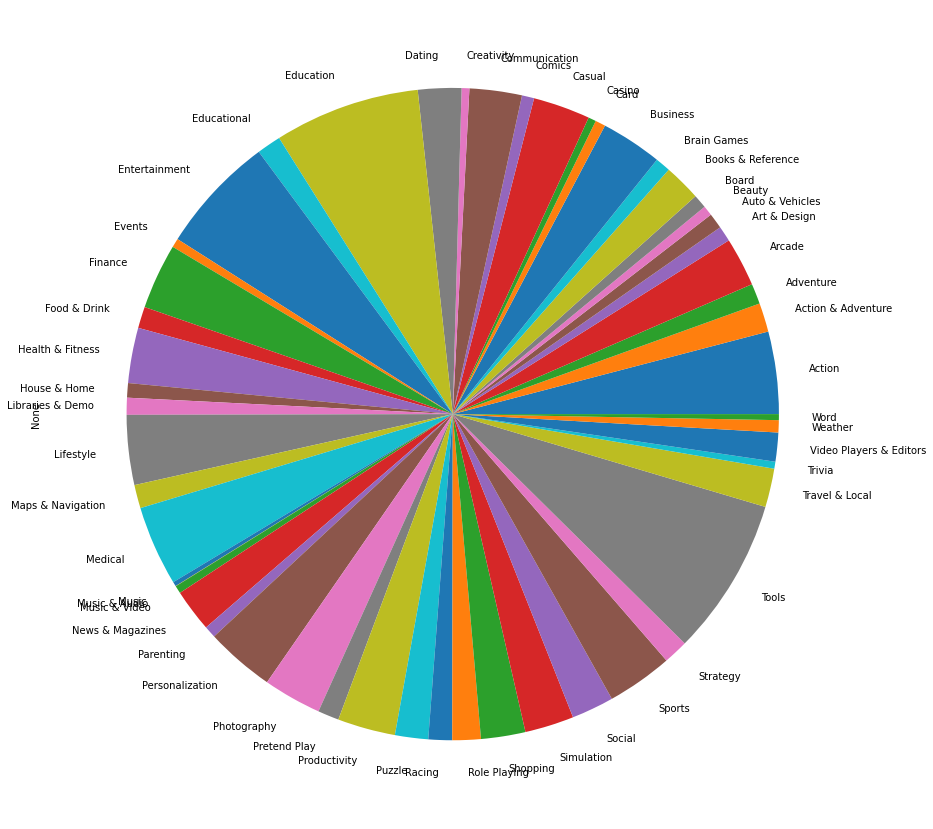

In [48]:
dfg = df.explode('Genres') #BOOM
dfg = dfg[['App', 'Genres']].copy() #grab app and genre columns for our convenience and potential future use
dfg = pd.concat([dfg.drop('Genres', axis=1), dfg.Genres.str.get_dummies()], axis=1)
counts = dfg.drop('App', axis=1).sum() #find sum of each unique genre
counts.plot.pie(figsize = (15,15)) #make it big because the default chart is unreadable

**2. Display a box plot of ratings for "Business" and "Education" categories. The boxplots should be in the same plot.**

([<matplotlib.axis.XTick at 0x19ee0304d60>,
 [Text(1, 0, 'Business'), Text(2, 0, 'Education')])

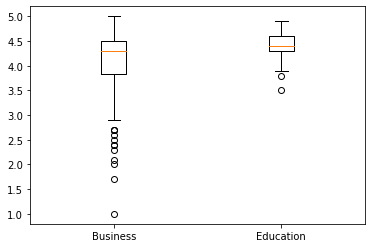

In [49]:
dfb = df[(df['Category'] == 'BUSINESS')] #grab business apps
dfe = df[(df['Category'] == 'EDUCATION')] #grab education apps
businessList = dfb['Rating'].tolist() #make a list of ratings 
educationList = dfe['Rating'].tolist() #same as above
plt.boxplot([businessList, educationList]) #simply plot the list of ratings
plt.xticks([1, 2], ['Business', 'Education'])